In [2]:
import os
import shutil
import json
import numpy as np
from typing import List

def process_landmark_annotations(
    json_path: str,
    output_dir: str,
    images_dir: str,
    normalize: bool = False
) -> None:
    """
    Process JSON facial landmark annotations and create organized .txt files for each image.

    Args:
        json_path (str): Path to the JSON file containing the landmark annotations.
        output_dir (str): Path to the output directory where 'images' and 'labels' folders will be created.
        images_dir (str): Path to the directory containing the original images.
        normalize (bool): If True, normalize landmark coordinates with respect to the image dimensions.

    Returns:
        None
    """
    # Define the ordered list of 72 landmarks
    landmarks_order = [
        f"face_contour_{i}" for i in range(1, 18)
    ] + [
        f"right_eyebrow_{i}" for i in range(18, 23)
    ] + [
        f"left_eyebrow_{i}" for i in range(23, 28)
    ] + [
        f"nose_bridge_{i}" for i in range(28, 32)
    ] + [
        f"nose_base_{i}" for i in range(32, 37)
    ] + [
        f"right_eye_{i}" for i in range(37, 43)
    ] + [
        f"left_eye_{i}" for i in range(43, 49)
    ] + [
        f"outer_lip_{i}" for i in range(49, 61)
    ] + [
        f"inner_lip_{i}" for i in range(61, 69)
    ] + [
        "under_lip_69", "upper_chin_70", "left_chin_71", "right_chin_72"
    ]

    # Create output directories
    images_output_dir = os.path.join(output_dir, "images")
    labels_output_dir = os.path.join(output_dir, "labels")
    os.makedirs(images_output_dir, exist_ok=True)
    os.makedirs(labels_output_dir, exist_ok=True)

    # Load the JSON annotations
    with open(json_path, 'r') as f:
        annotations = json.load(f)

    for annotation in annotations:
        # Extract image information
        image_path = annotation["image"].split("?d=")[-1]  # Clean up image path
        image_name = os.path.basename(image_path)
        original_width = annotation["landmarks"][0]["original_width"]
        original_height = annotation["landmarks"][0]["original_height"]

        # Initialize landmarks with NaN for each image
        landmarks_data = {key: (np.nan, np.nan) for key in landmarks_order}

        # Fill in available landmark data
        for landmark in annotation["landmarks"]:
            label = landmark["keypointlabels"][0]
            x, y = landmark["x"], landmark["y"]

            # **Step 1: Ensure desnormalization from 0-100 to absolute pixels**
            if 0 <= x <= 100 and 0 <= y <= 100:
                # Rescale x and y from [0, 100] to [0, original_width] and [0, original_height]
                x = (x / 100) * original_width
                y = (y / 100) * original_height

            # **Step 2: Normalize if requested**
            if normalize:
                x /= original_width
                y /= original_height

            # Convert to integer if not normalized
            if not normalize:
                x = int(round(x))
                y = int(round(y))

            landmarks_data[label] = (x, y)

        # Create a single line for this instance
        instance_line = " ".join(
            f"{x:.6f} {y:.6f}" if normalize else f"{x} {y}"
            if not (np.isnan(x) or np.isnan(y)) else "nan nan"
            for x, y in landmarks_data.values()
        )

        # Write the annotation to the .txt file
        txt_path = os.path.join(labels_output_dir, f"{os.path.splitext(image_name)[0]}.txt")
        with open(txt_path, 'w') as txt_file:
            txt_file.write(instance_line + "\n")

        # Copy image to output folder
        src_image_path = os.path.join(images_dir, image_name)
        dst_image_path = os.path.join(images_output_dir, image_name)
        if os.path.exists(src_image_path):
            shutil.copy(src_image_path, dst_image_path)
        else:
            print(f"Warning: Image {src_image_path} not found, skipping.")

    print(f"Processing complete. Output saved to {output_dir}.")




# Example usage
process_landmark_annotations(
    json_path="/Users/jocareher/Downloads/project-7-at-2024-12-19-10-49-a7493c64.json",
    output_dir="/Users/jocareher/Downloads/baby_face_72",
    images_dir="/Users/jocareher/Downloads/under_construction_dataset/Hospital_del_Mar",
    normalize=False
)


Processing complete. Output saved to /Users/jocareher/Downloads/baby_face_72.


In [3]:
import random
import matplotlib.pyplot as plt
import cv2


def plot_landmarks_grid(
    images_dir: str,
    labels_dir: str,
    grid_size: tuple = (3, 3),
    normalize: bool = False,
    image_count: int = 9
) -> None:
    """
    Plot a grid of images with their corresponding landmarks overlaid.

    Args:
        images_dir (str): Directory containing the images.
        labels_dir (str): Directory containing the .txt files with landmarks.
        grid_size (tuple): Number of rows and columns in the grid (e.g., (3, 3)).
        normalize (bool): Whether the landmark coordinates are normalized.
        image_count (int): Number of images to display (must fit in the grid).

    Returns:
        None
    """
    # List all image and label files
    image_files = sorted(os.listdir(images_dir))
    label_files = sorted(os.listdir(labels_dir))

    # Ensure each image has a corresponding label
    assert len(image_files) == len(label_files), "Mismatch between images and label files."

    # Randomly select images
    selected_indices = random.sample(range(len(image_files)), image_count)
    selected_images = [image_files[i] for i in selected_indices]
    selected_labels = [label_files[i] for i in selected_indices]

    # Set up the plot grid
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(grid_size[1] * 4, grid_size[0] * 4))
    axes = axes.flatten()

    for ax, image_file, label_file in zip(axes, selected_images, selected_labels):
        # Load image
        image_path = os.path.join(images_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for plotting

        # Load landmarks
        label_path = os.path.join(labels_dir, label_file)
        with open(label_path, 'r') as f:
            # Parse landmarks, handling "nan nan" cases
            landmarks = [
                list(map(float, line.strip().split())) if "nan" not in line else [np.nan, np.nan]
                for line in f.readlines()
            ]
            landmarks = np.array(landmarks, dtype=float)

        # Separate landmarks into x and y, ignoring NaN values
        x_coords = landmarks[:, 0]
        y_coords = landmarks[:, 1]
        valid_indices = ~np.isnan(x_coords) & ~np.isnan(y_coords)
        x_coords = x_coords[valid_indices]
        y_coords = y_coords[valid_indices]

        # If landmarks are normalized, scale to image size
        if normalize:
            x_coords *= image.shape[1]
            y_coords *= image.shape[0]

        # Plot landmarks on the image using cv2.circle
        for x, y in zip(x_coords, y_coords):
            cv2.circle(image, (int(x), int(y)), radius=30, color=(255, 0, 0), thickness=-1)

        # Display the image with landmarks
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(os.path.basename(image_file))

    plt.tight_layout()
    plt.show()

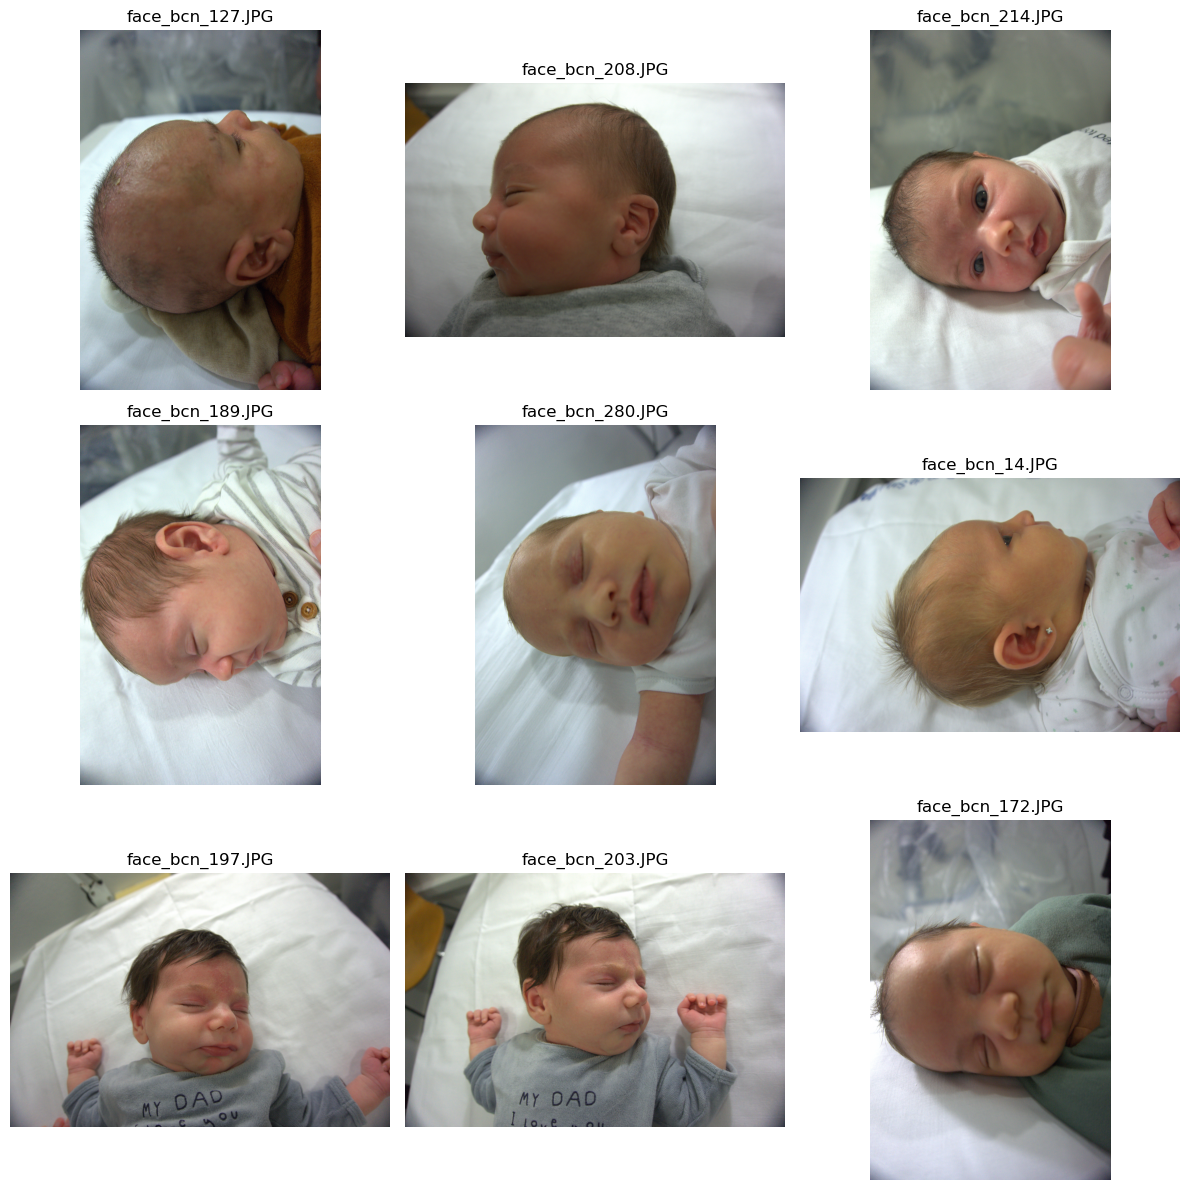

In [4]:
plot_landmarks_grid(
    images_dir="/Users/jocareher/Downloads/baby_face_72/images",
    labels_dir="/Users/jocareher/Downloads/baby_face_72/labels",
    grid_size=(3, 3), 
    normalize=False,   
    image_count=9    
)


In [5]:
import os
import numpy as np
import cv2

def load_landmarks_from_txt(file_path):
    """
    Lee landmarks desde un archivo .txt.
    Cada línea contiene pares x, y en secuencia, algunos pueden ser NaN.
    Devuelve un array de shape (N, 2) con N landmarks. 
    Los que sean NaN se dejan como np.nan.
    """
    if not os.path.exists(file_path) or os.stat(file_path).st_size == 0:
        return None

    with open(file_path, 'r') as f:
        line = f.readline().strip()
    
    coords = list(map(float, line.split()))
    
    if len(coords) % 2 != 0:
        print(f"Advertencia: el archivo {file_path} no tiene un número par de valores.")
        return None

    landmarks = np.array(coords).reshape(-1, 2)
    return landmarks

def draw_landmarks_on_image(image, landmarks, color=(0, 0, 255)):
    """
    Dibuja los landmarks sobre la imagen, ignorando los que tengan NaN.
    El tamaño del punto (radio) se ajusta según el tamaño de la imagen.
    """
    # Calcula un radio proporcional al tamaño de la imagen
    h, w = image.shape[:2]
    # Por ejemplo, tomar 1% del lado más corto como radio
    radius = max(1, int(min(h, w) * 0.005))
    thickness = -1  # -1 para un círculo relleno

    for (x, y) in landmarks:
        if not (np.isnan(x) or np.isnan(y)):
            cv2.circle(image, (int(round(x)), int(round(y))), radius, color, thickness)
    return image

def overlay_landmarks_on_images(image_dir, txt_dir, output_dir):
    """
    Recorre un directorio con imágenes, busca sus landmarks en el directorio txt_dir,
    dibuja los landmarks sobre la imagen y guarda el resultado en output_dir.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

    for img_file in image_files:
        base_name = os.path.splitext(img_file)[0]
        txt_file = base_name + '.txt'

        img_path = os.path.join(image_dir, img_file)
        txt_path = os.path.join(txt_dir, txt_file)

        if not os.path.exists(txt_path):
            print(f"No se encontró el archivo de landmarks para {img_file}, se omite.")
            continue

        # Cargar imagen
        image = cv2.imread(img_path)
        if image is None:
            print(f"No se pudo cargar la imagen {img_path}, se omite.")
            continue

        # Cargar landmarks
        landmarks = load_landmarks_from_txt(txt_path)
        if landmarks is None:
            print(f"No se pudo cargar landmarks desde {txt_path}, se omite.")
            continue

        # Dibujar landmarks sobre la imagen
        image_with_landmarks = draw_landmarks_on_image(image, landmarks)

        # Guardar en el directorio de salida
        output_path = os.path.join(output_dir, img_file)
        cv2.imwrite(output_path, image_with_landmarks)
        print(f"Guardada la imagen con landmarks en {output_path}")

# Ejemplo de uso:
image_dir = "/Users/jocareher/Downloads/baby_face_72/images"
txt_dir = "/Users/jocareher/Downloads/baby_face_72/labels"
output_dir = "/Users/jocareher/Downloads/plots_babyface72"
overlay_landmarks_on_images(image_dir, txt_dir, output_dir)


Guardada la imagen con landmarks en /Users/jocareher/Downloads/plots_babyface72/face_bcn_289.JPG
Guardada la imagen con landmarks en /Users/jocareher/Downloads/plots_babyface72/face_bcn_276.JPG
Guardada la imagen con landmarks en /Users/jocareher/Downloads/plots_babyface72/face_bcn_262.JPG
Guardada la imagen con landmarks en /Users/jocareher/Downloads/plots_babyface72/face_bcn_100.JPG
Guardada la imagen con landmarks en /Users/jocareher/Downloads/plots_babyface72/face_bcn_114.JPG
Guardada la imagen con landmarks en /Users/jocareher/Downloads/plots_babyface72/face_bcn_128.JPG
Guardada la imagen con landmarks en /Users/jocareher/Downloads/plots_babyface72/face_bcn_129.JPG
Guardada la imagen con landmarks en /Users/jocareher/Downloads/plots_babyface72/face_bcn_115.JPG
Guardada la imagen con landmarks en /Users/jocareher/Downloads/plots_babyface72/face_bcn_101.JPG
Guardada la imagen con landmarks en /Users/jocareher/Downloads/plots_babyface72/face_bcn_263.JPG
Guardada la imagen con landmar